<a href="https://colab.research.google.com/github/ItalianPepper/COVID19-Italy-Analysis/blob/master/coronavirus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Per gli Italiani / For Italians: Siate responsabili per voi stessi e i vostri cari. Osservate le normative del Governo Italiano.

I grafici mostrano esclusivamente i dati della [Protezione Civile.](https://github.com/pcm-dpc/COVID-19/blob/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv)

The charts plotting exclusively the data of [Protezione Civile.](https://github.com/pcm-dpc/COVID-19/blob/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv)

In [0]:
import urllib
# Download .csv file from official profile of Protezione Civile.
raw_git_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
csv_name = "dpc-covid19-ita-andamento-nazionale.csv"
urllib.request.urlretrieve(raw_git_url, csv_name)

Total Cases


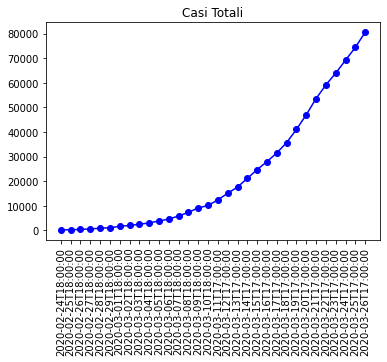

Healed - Deaths


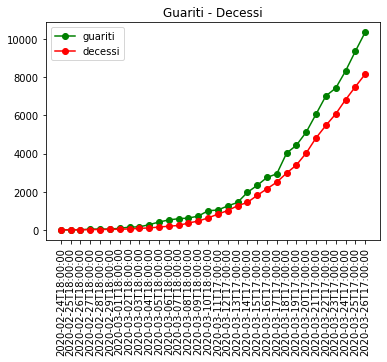

New Positives (difference with yersterday)


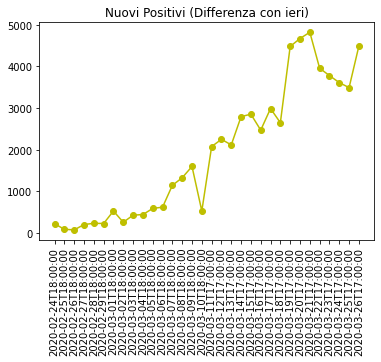

Swabs - Total Positives


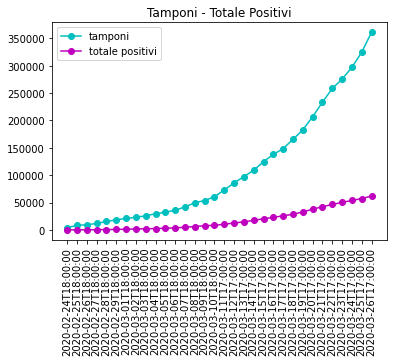

Hospitalized with symptoms - Intensitive Care - Home Isolation


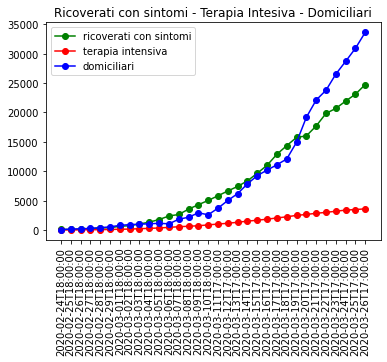

Positives - Deaths


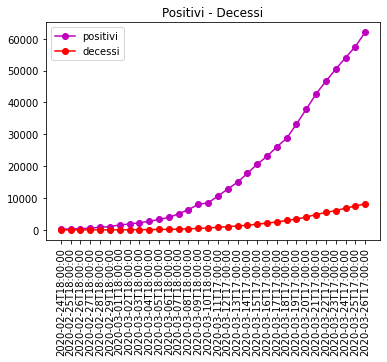

Ultimo aggiornamento / Last Update: 2020-03-26T17:00:00
Numero di casi / Number of Cases:  80539
Guariti / Healed:  10361
Decessi / Deaths:  8165
---
Last observations in percentage
Rapporto positivi - tamponi / Relationship between positives and swabs: 17.17526172935246
---
Tasso di letalità / Letality: 13.166594101236836
---


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

df_ita_covid = pd.read_csv(csv_name, sep=",", header=0)
tot_casi_col = df_ita_covid["totale_casi"].tolist()
tot_healed_col = df_ita_covid["dimessi_guariti"].tolist()
tot_deaths_col = df_ita_covid["deceduti"].tolist()
dates_col = df_ita_covid["data"].tolist()
new_positive_col = df_ita_covid["nuovi_attualmente_positivi"].tolist()
tot_actual_positive_col = df_ita_covid["totale_attualmente_positivi"].tolist()
tot_swabs_col = df_ita_covid["tamponi"].tolist()

tot_hospitalized = df_ita_covid["ricoverati_con_sintomi"].tolist()
tot_dom = df_ita_covid["isolamento_domiciliare"].tolist()
intensitive_care = df_ita_covid["terapia_intensiva"].tolist()


# Total cases
print("Total Cases")
plt.plot_date(dates_col, tot_casi_col, 'ob-', xdate=True, )
plt.title("Casi Totali")
plt.xticks(rotation=90)
plt.show()
plt.close()

# Healed - Deaths
print("Healed - Deaths")
plt.plot_date(dates_col, tot_healed_col, 'og-', xdate=True)
plt.plot_date(dates_col, tot_deaths_col, 'or-', xdate=True)
plt.title("Guariti - Decessi")
plt.legend(["guariti", "decessi"])
plt.xticks(rotation=90)
plt.show()
plt.close()


# New Positives
print("New Positives (difference with yersterday)")
plt.plot_date(dates_col, new_positive_col, 'oy-', xdate=True)
plt.title("Nuovi Positivi (Differenza con ieri)")
plt.xticks(rotation=90)
plt.show()
plt.close()

# Swabs - Tot positives
print("Swabs - Total Positives")
plt.plot_date(dates_col, tot_swabs_col, 'oc-', xdate=True)
plt.plot_date(dates_col, tot_actual_positive_col, 'om-', xdate=True)
plt.title("Tamponi - Totale Positivi")
plt.legend(["tamponi", "totale positivi"])
plt.xticks(rotation=90)
plt.show()
plt.close()


# Hospitalized with symptoms - Intensitive Care - Home Isolation
print("Hospitalized with symptoms - Intensitive Care - Home Isolation")
plt.plot_date(dates_col, tot_hospitalized, 'og-', xdate=True)

plt.plot_date(dates_col, intensitive_care, 'or-', xdate=True)
plt.plot_date(dates_col, tot_dom, 'ob-', xdate=True)
plt.title("Ricoverati con sintomi - Terapia Intesiva - Domiciliari")
plt.legend(["ricoverati con sintomi", "terapia intensiva", "domiciliari"])
plt.xticks(rotation=90)
plt.show()
plt.close()

#Tot Positives - Deaths
print("Positives - Deaths")
plt.plot_date(dates_col, tot_actual_positive_col, 'om-', xdate=True)
plt.plot_date(dates_col, tot_deaths_col, 'or-', xdate=True)
plt.title("Positivi - Decessi")
plt.legend(["positivi", "decessi"])
plt.xticks(rotation=90)
plt.show()
plt.close()

last_date = dates_col[len(dates_col)-1]

print("Ultimo aggiornamento / Last Update:", last_date)
print("Numero di casi / Number of Cases: ", tot_casi_col[len(tot_casi_col)-1]);
print("Guariti / Healed: ", tot_healed_col[len(tot_healed_col)-1]);
print("Decessi / Deaths: ", tot_deaths_col[len(tot_deaths_col)-1]);
print("---")


last_obs_deaths = tot_deaths_col[len(tot_deaths_col)-1]
last_obs_positives = tot_actual_positive_col[len(tot_actual_positive_col)-1]

letality_percent = (last_obs_deaths/last_obs_positives)*100


last_obs_swabs = tot_swabs_col[len(tot_swabs_col)-1]
pos_swabs_ratio = (last_obs_positives/last_obs_swabs)*100

print("Last observations in percentage")
print("Rapporto positivi - tamponi / Relationship between positives and swabs:",
      pos_swabs_ratio)
print("---")

print("Tasso di letalità / Letality:", 
      letality_percent)
print("---")

#Forecasts

In [76]:
import urllib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import datetime

def run_model(dates, col_selected, look_forward=3):
  x = []
  y = []

  for i in range(look_forward, len(col_selected)):

    x.append([col_selected[i-look_forward:i]])
    y.append(col_selected[i])

  x = np.array(x).reshape(len(x), look_forward)
  y = np.array(y).reshape(len(y))


  date_format = "%Y-%m-%dT%H:%M:%S"
  
  # Future elements for forecast
  futures_dates = []
  start_date = dates[0]
  start_date = datetime.datetime.strptime(start_date, date_format)
  
  futures_x = [i for i in range(len(col_selected), len(col_selected)+look_forward)]
  futures_x = np.array(futures_x).reshape(len(futures_x), 1)

  for i in range(len(col_selected), (len(col_selected) + look_forward)):
    futures_dates.append((start_date + datetime.timedelta(days=i)).strftime(date_format))

  x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.1,
                                                        shuffle=False)
  
  params = {"C":[0.1, 0.01, 0.001, 0.0001, 1.0, 2.0, 3.0, 5.0, 10.0, 100.0],
            "epsilon":[0.1, 0.01, 0.001, 0.0001, 0.00001, 1.0, 2.0],
            "max_iter":[1000000]}
            
  cv_model = LinearSVR()
  rscv = GridSearchCV(cv_model, params, n_jobs=-1)
  rscv.fit(x_train, y_train)
  
  model = LinearSVR()
  model.set_params(**rscv.best_params_)
  model.fit(x_train, y_train)

  pred = model.predict(x_test)
  
  error_abs = mean_absolute_error(y_test, pred)
  error_mse = mean_squared_error(y_test, pred)

  print('Test MAE: %.3f' % error_abs)
  print('Test MSE: %.3f' % error_mse)

  last_x = x_test[len(x_test)-1].tolist()
  last_y = y_test[len(y_test)-1].tolist()

  last_x.pop(0)
  last_x.append(last_y)

  next_day = np.array(last_x).reshape(-1, look_forward)
  forecast = model.predict(next_day)
  print(futures_dates[0], ":", int(forecast[0]))
  
  """
  forecast = model.predict(poly_futures_x)
  
  for i in range(0, len(forecast)):
    print(futures_dates[i], ":", int(forecast[i]))
  print("---")
  """

df_ita_covid = pd.read_csv(csv_name, sep=",", header=0)
tot_cases_col = df_ita_covid["totale_casi"].tolist()
tot_healed_col = df_ita_covid["dimessi_guariti"].tolist()
tot_deaths_col = df_ita_covid["deceduti"].tolist()
dates_col = df_ita_covid["data"].tolist()


print("Previsioni / Forecasts")
print("Casi Totali / Total Cases")
run_model(dates_col, tot_cases_col, look_forward=4)
print("---")
print("Guariti / Healed")
run_model(dates_col, tot_healed_col, look_forward=4)
print("---")
print("Decessi / Deaths")
run_model(dates_col, tot_deaths_col, look_forward=4)
print("---")

Previsioni / Forecasts
Casi Totali / Total Cases


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test MAE: 2782.497
Test MSE: 8797579.148
2020-03-27T18:00:00 : 82960
---
Guariti / Healed


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test MAE: 626.306
Test MSE: 396680.691
2020-03-27T18:00:00 : 12309
---
Decessi / Deaths


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test MAE: 144.272
Test MSE: 21429.948
2020-03-27T18:00:00 : 8617
---


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




#SIR Epidemic model
## This is just a tryout.
### For more details: [Scipython - SIR](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

S = not infected people

I = number of infected people

R = are the people that have recovered from disease and now have immunity

Parameters:

beta = contract rate. I've calculate considering the relationship between the last two obsvervations of column "positivi" (positives in Italian).

gamma = the mean recovery rate. I don't know so I suppose that each people stay 30 days in hospital.

N = Italy population (approximately)

infected_0 = last observation of positive people

recovered_0 = last observation of recovered people


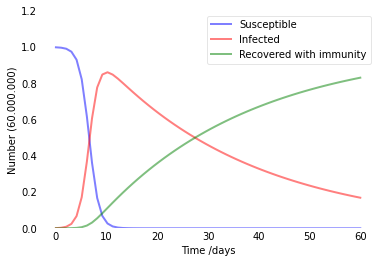

In [77]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

df_ita_covid = pd.read_csv(csv_name, sep=",", header=0)
tot_actual_positive_col = df_ita_covid["totale_attualmente_positivi"].tolist()
tot_healed_col = df_ita_covid["dimessi_guariti"].tolist()

infected_0 = tot_actual_positive_col[len(tot_actual_positive_col)-1]
recovery_0 = tot_healed_col[len(tot_healed_col)-1]

"""
# mean average of growing of infected: x_i/x_i-1
def get_beta(infected_col):
  tot_sum_beta = 0
  for i in range(1, len(infected_col)):
    prev = infected_col[i-1]
    actual = infected_col[i]
    beta_i = actual/prev
    tot_sum_beta += beta_i
  
  tot_sum_beta /= len(infected_col)
  return tot_sum_beta

beta = get_beta(tot_actual_positive_col)
"""

beta_1 = infected_0/tot_actual_positive_col[len(tot_actual_positive_col)-2]
N = 60000000
gamma_1 = 1./30

def run_sir_model(N, I0, R0, beta, gamma):
  # Everyone else, S0, is susceptible to infection initially.
  S0 = N - I0 - R0
  # A grid of time points (in days)
  t = np.linspace(0, 60, 60)

  # The SIR model differential equations.
  def deriv(y, t, N, beta, gamma):
      S, I, R = y
      dSdt = -beta * S * I / N
      dIdt = beta * S * I / N - gamma * I
      dRdt = gamma * I
      return dSdt, dIdt, dRdt

  # Initial conditions vector
  y0 = S0, I0, R0
  # Integrate the SIR equations over the time grid, t.
  ret = odeint(deriv, y0, t, args=(N, beta, gamma))
  S, I, R = ret.T

  # Plot the data on three separate curves for S(t), I(t) and R(t)
  fig = plt.figure(facecolor='w')
  ax = fig.add_subplot(111, axisbelow=True)
  ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
  ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
  ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
  ax.set_xlabel('Time /days')
  ax.set_ylabel('Number (60.000.000)')
  ax.set_ylim(0,1.2)
  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show()

run_sir_model(N, infected_0, recovery_0, beta_1, gamma_1)